In [1]:
import numpy as np
from pandas import Series
import seaborn as sns
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
# Read Excel file and convert it to CSV
excel_file = '../../../Data_Thesis/CNS/Data/Excell_exports/CACO3_TEST_PWD_ST.14_areas.XLS'
csv_file = '../../../Data_Thesis/CNS/Data/Areas/GOM22SU_ST.14_PWD_areas.csv'
df = pd.read_excel(excel_file)
df.to_csv(csv_file, index=False, header=False)

# Read CSV file and create a DataFrame
column_names = ['name', 'file', 'date', 'time', 'type', 'wtd', 'Unnamed_1', 'Unnamed_2', 'Unnamed_3','Unnamed_4', 'N_area', 'C_area', 'S_area']  # Replace with your desired column names
df = pd.read_csv(csv_file, names=column_names)

# Now you can work with the DataFrame
CAMP = "NA" 
STN = "NA"
TREAT = "CaCO3"

Save_name = '../../../Data_Thesis/CNS/Data/CaCO3_test.csv'

In [3]:
df

,name,file,date,time,type,wtd,Unnamed_1,Unnamed_2,Unnamed_3,Unnamed_4,N_area,C_area,S_area
0,Blank,DfchA002,07/13/2023,20:19,Blank,NaN,NaN,NaN,NaN,NaN,0.0,1.636791e+04,0.0
0,Blank,DfchA003,07/13/2023,20:31,Blank,NaN,NaN,NaN,NaN,NaN,0.0,1.538791e+04,0.0
0,Blank,DfchA004,07/13/2023,20:43,Blank,NaN,NaN,NaN,NaN,NaN,0.0,2.094462e+04,0.0
0,Blank,DfchA005,07/13/2023,20:55,Blank,NaN,NaN,NaN,NaN,NaN,0.0,1.514653e+04,0.0
0,tin,DfchA006,07/13/2023,21:07,By-Pass,NaN,NaN,NaN,NaN,NaN,0.0,1.909253e+04,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Blank,DfchA059,07/14/2023,07:47,Blank,NaN,NaN,NaN,NaN,NaN,0.0,6.333532e+06,0.0
0,Blank,DfchA060,07/14/2023,07:59,Blank,NaN,NaN,NaN,NaN,NaN,8987673.0,0.000000e+00,0.0
0,Blank,DfchA061,07/14/2023,08:11,Blank,NaN,NaN,NaN,NaN,NaN,18814684.0,0.000000e+00,0.0
0,Blank,DfchA062,07/14/2023,08:35,Blank,NaN,NaN,NaN,NaN,NaN,14018846.0,0.000000e+00,0.0


In [4]:
# Calculate mean for rows where type is blank
blank_rows = df[df['type'] == 'Blank']
mean_values = blank_rows[['C_area', 'N_area', 'S_area']].mean()

# Subtract mean from respective columns and create new rows
df['N_area_bl'] = df['N_area']# - mean_values['N_area']
df['C_area_bl'] = df['C_area']# - mean_values['C_area']
df['S_area_bl'] = df['S_area']# - mean_values['S_area']

In [5]:
# Calculate C N S wights 
std = df[df['type'] == 'STD']

# Subtract mean from respective columns and create new rows
std['N_wtd'] = std['wtd'] * .0652
std['C_wtd'] = std['wtd'] * .725
std['S_wtd'] = std['wtd'] * .0746

std

C:\Users\12532\AppData\Local\Temp\ipykernel_16056\2823902847.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std['N_wtd'] = std['wtd'] * .0652
C:\Users\12532\AppData\Local\Temp\ipykernel_16056\2823902847.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std['C_wtd'] = std['wtd'] * .725
C:\Users\12532\AppData\Local\Temp\ipykernel_16056\2823902847.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,name,file,date,time,type,wtd,Unnamed_1,Unnamed_2,Unnamed_3,Unnamed_4,N_area,C_area,S_area,N_area_bl,C_area_bl,S_area_bl,N_wtd,C_wtd,S_wtd
0,low,DfchA007,07/13/2023,21:19,STD,1.376,6.25,0.0,NaN,NaN,304168.18750,5622019.5,33977.0,304168.18750,5622019.5,33977.0,0.089715,0.997600,0.102650
0,mid,DfchA008,07/13/2023,21:31,STD,2.482,6.25,0.0,NaN,NaN,504700.40625,10031425.0,165482.0,504700.40625,10031425.0,165482.0,0.161826,1.799450,0.185157
0,high,DfchA009,07/13/2023,21:43,STD,4.909,6.25,0.0,NaN,NaN,994312.68750,19662282.0,544568.5,994312.68750,19662282.0,544568.5,0.320067,3.559025,0.366211


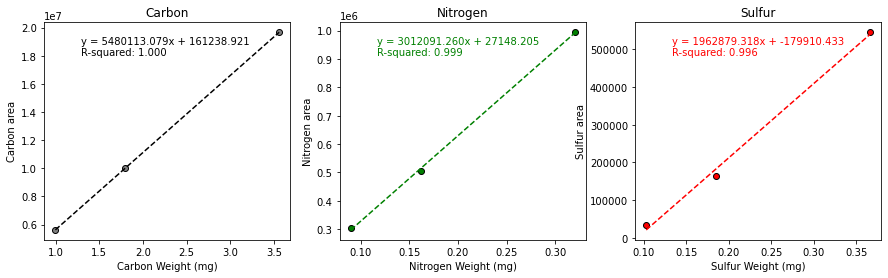

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Scatter plot and linear regression for C_wtd vs C_area
ax = axes[0]
ax.scatter(std['C_wtd'], std['C_area_bl'], facecolor='grey', edgecolor='black')
x = std['C_wtd']
y = std['C_area_bl']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='black', linestyle='--')
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
ax.set_xlabel('Carbon Weight (mg)')
ax.set_ylabel('Carbon area')
ax.set_title('Carbon')
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=10, color='black')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=10, color='black')

# Scatter plot and linear regression for N_wtd vs N_area
ax = axes[1]
ax.scatter(std['N_wtd'], std['N_area_bl'], facecolor='green', edgecolor='black')
x = std['N_wtd']
y = std['N_area_bl']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='green', linestyle='--')
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
ax.set_xlabel('Nitrogen Weight (mg)')
ax.set_ylabel('Nitrogen area')
ax.set_title('Nitrogen')
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=10, color='green')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=10, color='green')

# Scatter plot and linear regression for S_wtd vs S_area
ax = axes[2]
ax.scatter(std['S_wtd'], std['S_area_bl'], facecolor='red', edgecolor='black')
x = std['S_wtd']
y = std['S_area_bl']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
ax.set_xlabel('Sulfur Weight (mg)')
ax.set_ylabel('Sulfur area')
ax.set_title('Sulfur')
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=10, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=10, color='red')

# show plot
plt.show()

In [7]:
y = std['C_wtd']
x = std['C_area_bl']
C_coefficients = np.polyfit(x, y, 1)
C_slope = C_coefficients[0]

y = std['N_wtd']
x = std['N_area_bl']
N_coefficients = np.polyfit(x, y, 1)
N_slope = N_coefficients[0]

y = std['S_wtd']
x = std['S_area_bl']
S_coefficients = np.polyfit(x, y, 1)
S_slope = S_coefficients[0]

print(f"SLOPE")
print(f"Carbon slope:   {C_slope}")
print(f"Nitrogen slope: {N_slope}")
print(f"Sulfur slope:   {S_slope}")
print(f"")

# Subtract mean from respective columns and create new rows
df['N_wtd'] = df['N_area_bl'] * N_slope
df['C_wtd'] = df['C_area_bl'] * C_slope
df['S_wtd'] = df['S_area_bl'] * S_slope

# Subtract mean from respective columns and create new rows
df['N%'] = df['N_wtd'] / df['wtd'] *100
df['C%'] = df['C_wtd'] / df['wtd'] *100
df['S%'] = df['S_wtd'] / df['wtd'] *100

cs = df[df['name'].str.contains('CS')]
cs['cs_N%'] = cs['N%']/.0652 * 100
cs['cs_C%'] = cs['C%']/.725 * 100
cs['cs_S%'] = cs['S%']/.0746 *100 

ca = df[df['name'].str.contains('CA')]
ca['ca_C%'] = ca['C%']/.1199 *100

print(f"Check Standerd % est")
print('Nitrogen')
print(cs['cs_N%'])
print('Carbon')
print(cs['cs_C%'])
print('Sulfer')
print(cs['cs_S%'])
print('CaCO3')
print(ca['ca_C%'])


SLOPE
Carbon slope:   1.8247776154978996e-07
Nitrogen slope: 3.317932732977153e-07
Sulfur slope:   5.076021840304106e-07

Check Standerd % est
Nitrogen
0    690441.931660
0    198227.227425
Name: cs_N%, dtype: float64
Carbon
0       0.000000
0    7330.445497
Name: cs_C%, dtype: float64
Sulfer
0    0.0
0    0.0
Name: cs_S%, dtype: float64
CaCO3
0     45.182400
0     52.112089
0    123.370787
0    124.723851
0     99.614012
Name: ca_C%, dtype: float64


C:\Users\12532\AppData\Local\Temp\ipykernel_16056\1654424845.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs['cs_N%'] = cs['N%']/.0652 * 100
C:\Users\12532\AppData\Local\Temp\ipykernel_16056\1654424845.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs['cs_C%'] = cs['C%']/.725 * 100
C:\Users\12532\AppData\Local\Temp\ipykernel_16056\1654424845.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [8]:
df.to_csv('../../../Data_Thesis/CNS/Data/CaCO3_test_full.csv')
ca.to_csv('../../../Data_Thesis/CNS/Data/CaCO3_test_new.csv')

In [9]:
ds = df[df['name'].str.contains('CA')]
ds['ID'] = ds['name'].str[-2:]
ds['Treat'] = CAMP
ds['Camp'] = TREAT
ds['Station'] = STN
ds['notes'] = "note"

selected_columns = ['ID', 'Treat', 'Camp', 'Station', 'N%', 'C%', 'S%', 'notes']
ds = ds[selected_columns]

ds.to_csv(Save_name, index=False, header=True)
ds

C:\Users\12532\AppData\Local\Temp\ipykernel_16056\2321342454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['ID'] = ds['name'].str[-2:]
C:\Users\12532\AppData\Local\Temp\ipykernel_16056\2321342454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['Treat'] = CAMP
C:\Users\12532\AppData\Local\Temp\ipykernel_16056\2321342454.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,ID,Treat,Camp,Station,N%,C%,S%,notes
0,01,NA,CaCO3,NA,0.0,0.054174,0.0,note
0,02,NA,CaCO3,NA,0.0,0.062482,0.0,note
0,03,NA,CaCO3,NA,0.0,0.147922,0.0,note
0,04,NA,CaCO3,NA,0.0,0.149544,0.0,note
0,05,NA,CaCO3,NA,0.0,0.119437,0.0,note
